## 单细胞 ATAC 和 RNA 图谱注释

### 工具包加载

In [261]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
import os
import joblib
import importlib
from typing import Optional, Tuple, Union
from scipy.sparse import csr_matrix
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import pdist
import snapatac2 as snap

### 数据读取

In [157]:
rna_adata = ad.read_h5ad("/data/wzy_data/IntegrAnal_scATAC_scRNA_sql/athMD/data/intermediate/scglue/rna_harmony_adata.h5ad")
rna_ctrl_adata = ad.read_h5ad("/data/wzy_data/IntegrAnal_scATAC_scRNA_sql/athMD/data/intermediate/scglue/rna_ctrl_adata.h5ad")
rna_treat_adata = ad.read_h5ad("/data/wzy_data/IntegrAnal_scATAC_scRNA_sql/athMD/data/intermediate/scglue/rna_treat_adata.h5ad")

atac_adata = ad.read_h5ad("/data/wzy_data/IntegrAnal_scATAC_scRNA_sql/athMD/data/intermediate/scglue/atac_harmony_adata.h5ad")
atac_gene_mat_adata = ad.read_h5ad("/data/wzy_data/IntegrAnal_scATAC_scRNA_sql/athMD/data/intermediate/scglue/atac_harmony_gene_matrix.h5ad")
atac_peak_mat_adata = ad.read_h5ad("/data/wzy_data/IntegrAnal_scATAC_scRNA_sql/athMD/data/intermediate/scglue/atac_harmony_peak_mat.h5ad")
atac_ctrl_adata = ad.read_h5ad("/data/wzy_data/IntegrAnal_scATAC_scRNA_sql/athMD/data/intermediate/scglue/atac_ctrl_adata.h5ad")
atac_treat_adata = ad.read_h5ad("/data/wzy_data/IntegrAnal_scATAC_scRNA_sql/athMD/data/intermediate/scglue/atac_treat_adata.h5ad")

scglue_adata = ad.read_h5ad("/data/wzy_data/IntegrAnal_scATAC_scRNA_sql/pipeline_py/data/scglue/scglue_combined.h5ad")

### 数据预处理

处理 barcodes 标签避免重复：

In [167]:
rna_adata.obs.index = "scRNAseq_" + rna_adata.obs.index.astype(str)
atac_gene_mat_adata.obs.index = "snATACseq_" + atac_gene_mat_adata.obs.index.astype(str)
scglue_adata.obs.index = scglue_adata.obs.index.str.replace("RNA_", "scRNAseq_").str.replace("ATAC_", "snATACseq_")

传递细胞类型注释：

In [168]:
rna_adata.obs["cell_type_scglue"] = rna_adata.obs.index.map(scglue_adata.obs["cell_type_v2"].to_dict())
atac_gene_mat_adata.obs["cell_type_scglue"] = atac_gene_mat_adata.obs.index.map(scglue_adata.obs["cell_type_v2"].to_dict())

计算单细胞数据质量：

In [210]:
rna_ctrl_adata.obs["pct_counts_organelle"] = rna_ctrl_adata.obs["pct_counts_mt"] + rna_ctrl_adata.obs["pct_counts_cp"]
rna_treat_adata.obs["pct_counts_organelle"] = rna_treat_adata.obs["pct_counts_mt"] + rna_treat_adata.obs["pct_counts_cp"]

计算 ATAC 中的 FRiP：

In [274]:
snap.metrics.frip(
	adata=atac_ctrl_adata,
	regions={"Peaks": atac_peak_mat_adata.var_names.to_series().to_list()},
	normalized=True,
	count_as_insertion=False,
	inplace=True,
	n_jobs=20
)

snap.metrics.frip(
	adata=atac_treat_adata,
	regions={"Peaks": atac_peak_mat_adata.var_names.to_series().to_list()},
	normalized=True,
	count_as_insertion=False,
	inplace=True,
	n_jobs=20
)

### RNA 聚类 UMAP 图

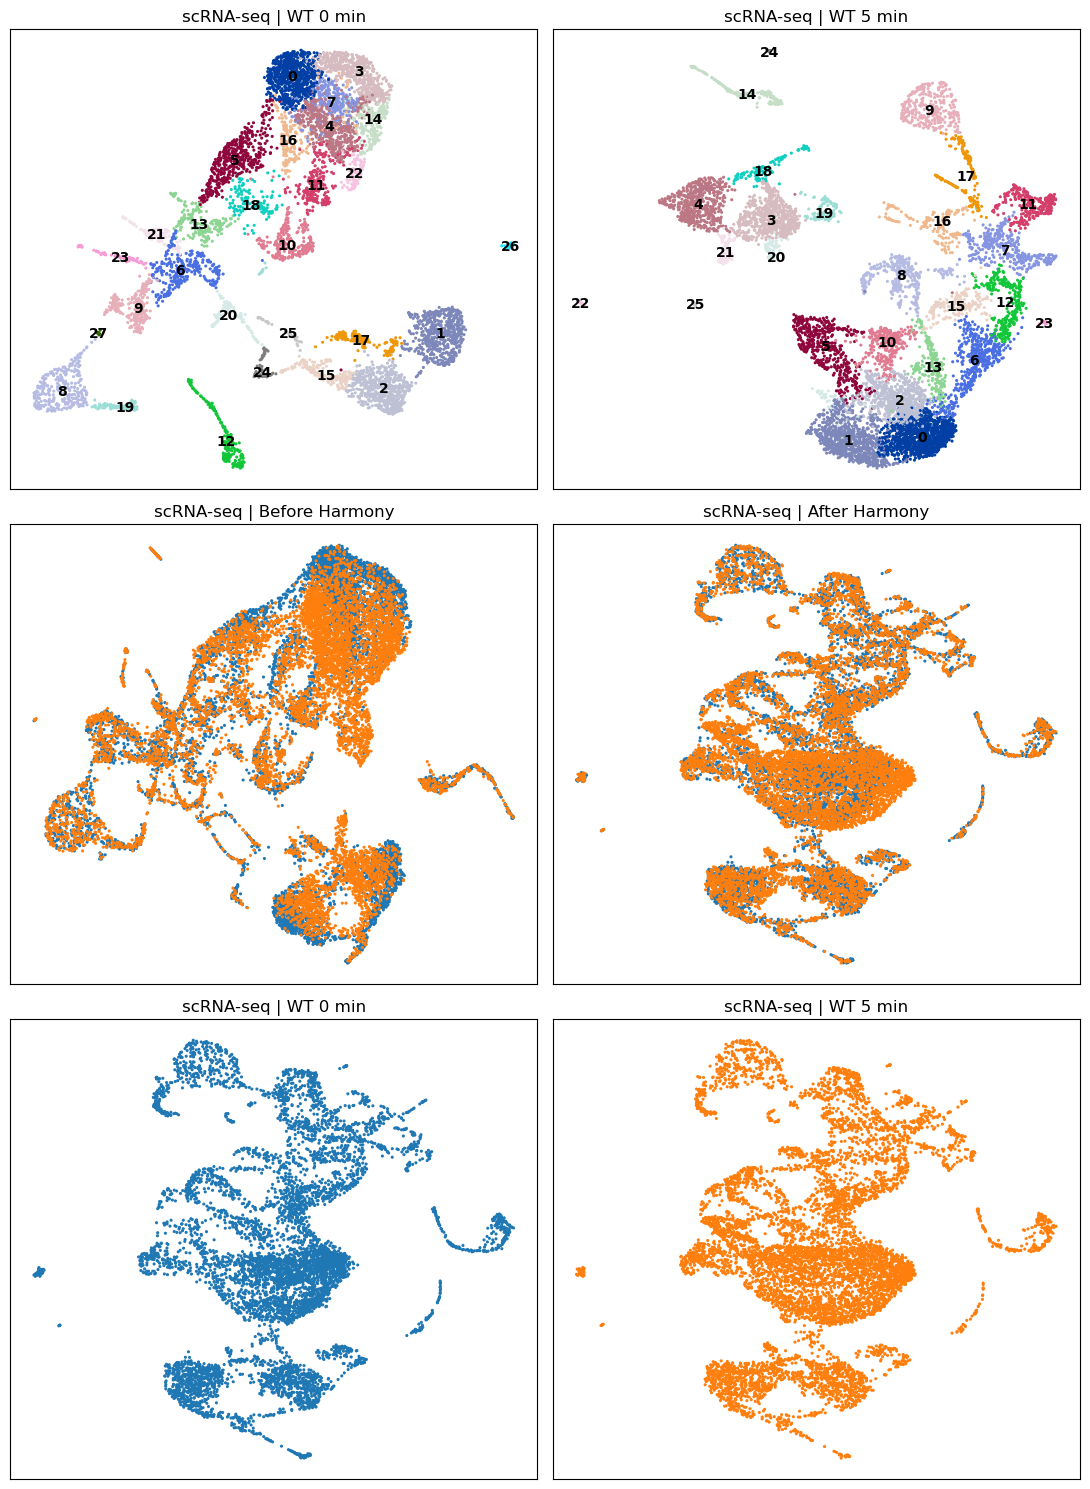

In [132]:
fig, axes = plt.subplots(3, 2, figsize=(11, 15))

sc.pl.embedding(
    rna_ctrl_adata,
    basis="X_umap",
    color="leiden",
    use_raw=None,
    layer=None,
    legend_loc="on data",
    title="scRNA-seq | WT 0 min",
    size=20,
    ax=axes[0, 0],
    show=False
)

sc.pl.embedding(
    rna_treat_adata,
    basis="X_umap",
    color="leiden",
    use_raw=None,
    layer=None,
    legend_loc="on data",
    title="scRNA-seq | WT 5 min",
    size=20,
    ax=axes[0, 1],
    show=False
)

sc.pl.embedding(
    rna_adata,
    basis="X_umap_before_harmony",
    color="Dataset",
    use_raw=None,
    layer=None,
    legend_loc=None,
    title="scRNA-seq | Before Harmony",
    size=20,
    ax=axes[1, 0],
    show=False
)

sc.pl.embedding(
    rna_adata,
    basis="X_umap_harmony",
    color="Dataset",
    use_raw=None,
    layer=None,
    legend_loc=None,
    title="scRNA-seq | After Harmony",
    size=20,
    ax=axes[1, 1],
    show=False
)

sc.pl.embedding(
    rna_adata[rna_adata.obs["Dataset"] == "CTRL"],
    basis="X_umap_harmony",
    color="Dataset",
    use_raw=None,
    layer=None,
    legend_loc=None,
    title="scRNA-seq | WT 0 min",
    size=20,
    ax=axes[2, 0],
    show=False
)

sc.pl.embedding(
    rna_adata[rna_adata.obs["Dataset"] == "TREAT"],
    basis="X_umap_harmony",
    color="Dataset",
    use_raw=None,
    layer=None,
    legend_loc=None,
    title="scRNA-seq | WT 5 min",
    size=20,
    ax=axes[2, 1],
    show=False
)

axes[0, 0].set_xlabel("")
axes[0, 0].set_ylabel("")
axes[0, 1].set_xlabel("")
axes[0, 1].set_ylabel("")
axes[1, 0].set_xlabel("")
axes[1, 0].set_ylabel("")
axes[1, 1].set_xlabel("")
axes[1, 1].set_ylabel("")
axes[2, 0].set_xlabel("")
axes[2, 0].set_ylabel("")
axes[2, 1].set_xlabel("")
axes[2, 1].set_ylabel("")

plt.tight_layout()
plt.show()

### Marker 基因表达模式图

categories: 0, 1, 2, etc.
var_group_labels: Sieve Element, Cell Cycle, Myrosin Idioblast, etc.


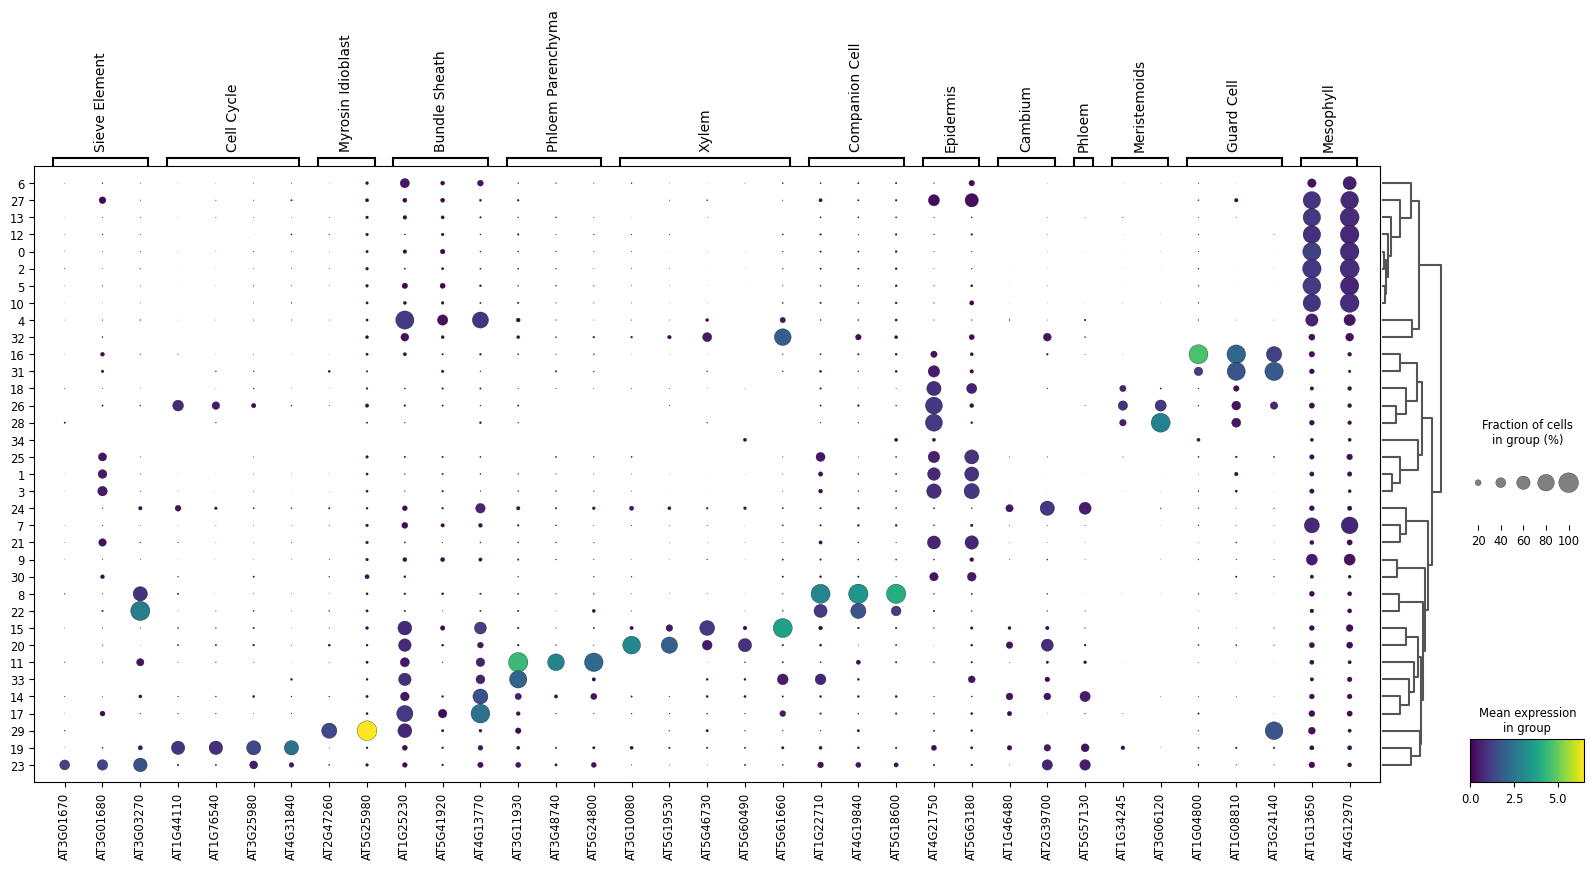

In [114]:
markers_lst = [
    "AT3G01670", "AT3G01680", "AT3G03270", # Sieve Element
    "AT1G44110", "AT1G76540", "AT3G25980", "AT4G31840", # Cell Cycle
    "AT2G47260", "AT5G25980", # Myrosin Idioblast
    "AT1G25230", "AT5G41920", "AT4G13770", # Bundle Sheath
    "AT3G11930", "AT3G48740", "AT5G24800", # Phloem Parenchyma
    "AT3G10080", "AT5G19530", "AT5G46730", "AT5G60490", "AT5G61660", # Xylem
    "AT1G22710", "AT4G19840", "AT5G18600", # Companion Cell
    "AT4G21750", "AT5G63180", # Epidermis
    "AT1G46480", "AT2G39700", # Cambium
    "AT5G57130", # Phloem
    "AT1G34245", "AT3G06120", # Meristemoids
    "AT1G04800", "AT1G08810", "AT3G24140", # Guard Cell
    "AT1G13650", "AT4G12970", # Mesophyll
]

sc.pl.DotPlot(
	adata=rna_adata,
	var_names=markers_lst,
	groupby="leiden_res_1.2",
	use_raw=True,
	log=False,
	figsize=(20,8),
	gene_symbols=None,
	var_group_positions=[(0,2), (3,6), (7,8), (9,11), (12,14), (15,19), (20,22), (23,24), (25,26), (27,27), (28,29), (30,32), (33,34)],
	var_group_labels=["Sieve Element", "Cell Cycle", "Myrosin Idioblast", "Bundle Sheath", "Phloem Parenchyma", "Xylem", "Companion Cell", "Epidermis", "Cambium", "Phloem", "Meristemoids", "Guard Cell", "Mesophyll"],
	var_group_rotation=None,
	layer=None,
	title=None,
	expression_cutoff=0.0,
	mean_only_expressed=False,
	standard_scale=None,
	cmap="viridis"
).add_dendrogram().show()

### RNA 注释 UMAP 图

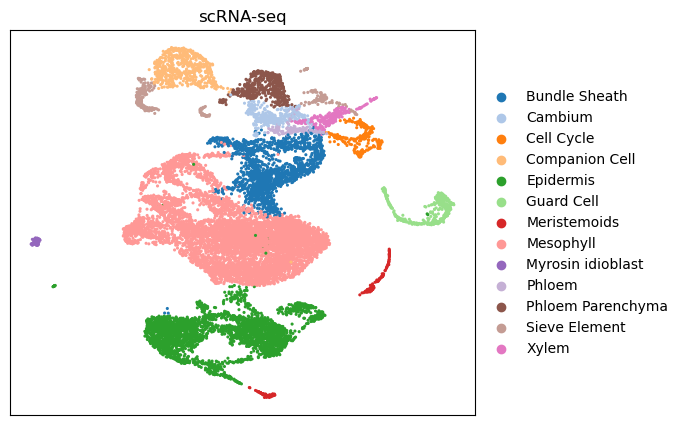

In [118]:
fig, ax = plt.subplots(figsize=(6, 5))

sc.pl.embedding(
    adata=rna_adata,
    basis="X_umap_harmony",
    color="cell_type_v2",
    palette=sc.pl.palettes.vega_20,
    use_raw=None,
    layer=None,
    legend_loc="right margin",
    title="scRNA-seq",
    size=20,
    ax=ax,
    show=False
)

ax.set_xlabel("")
ax.set_ylabel("")

plt.show()

### ATAC 聚类 UMAP 图

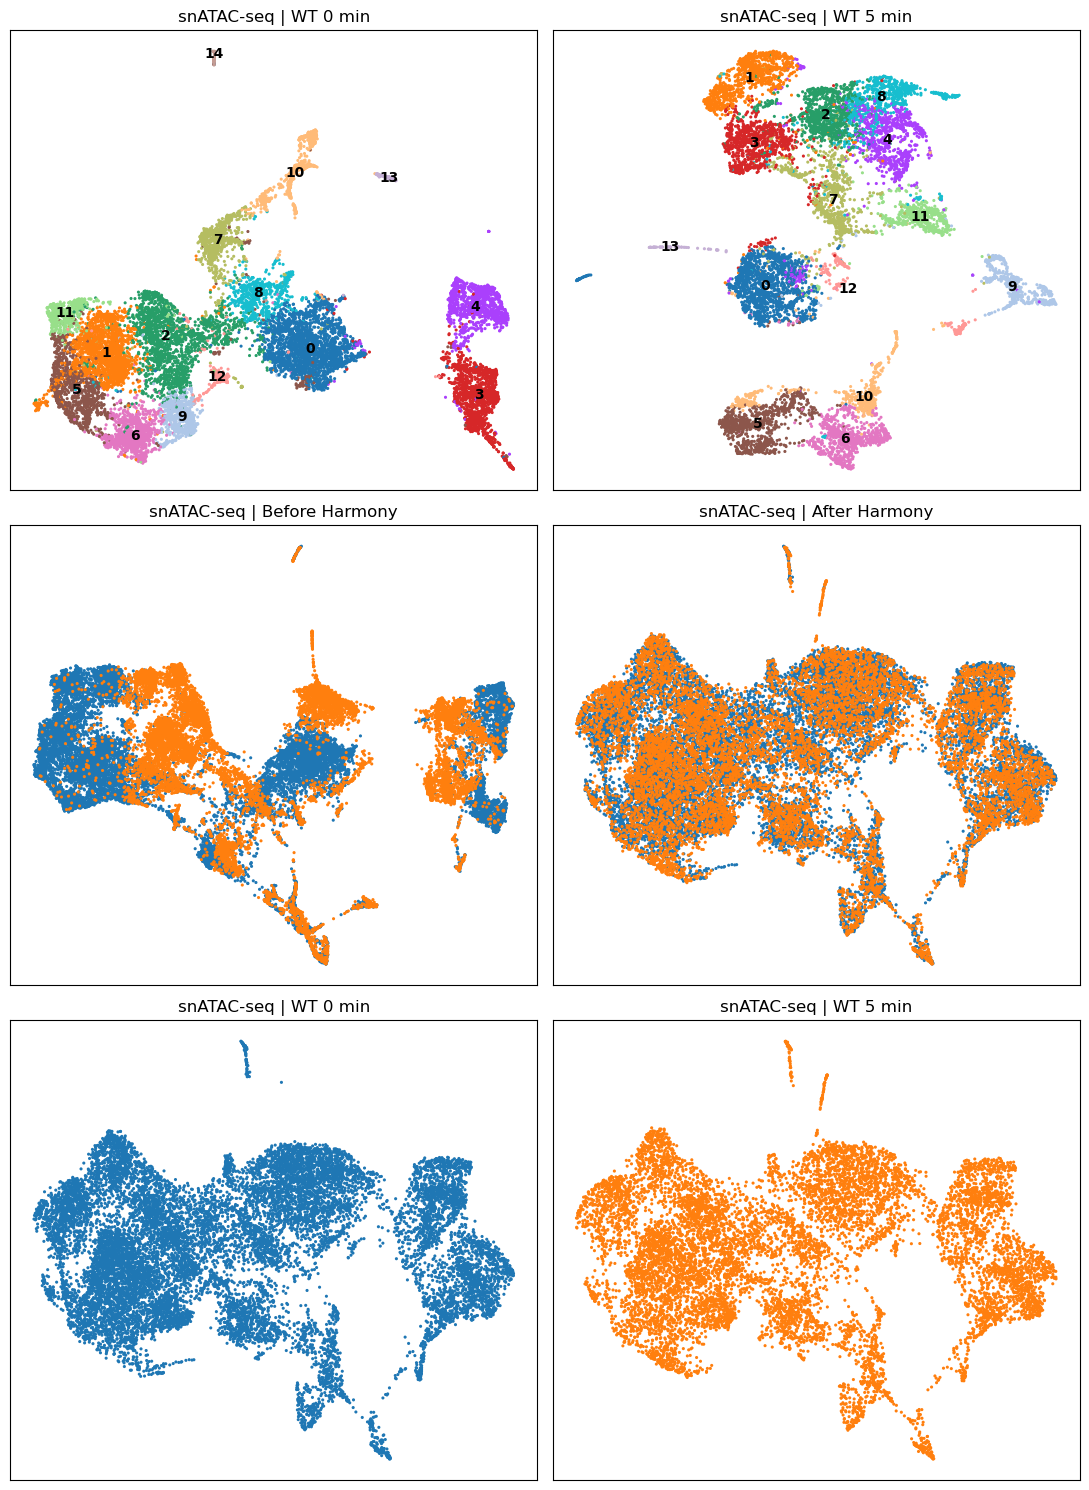

In [136]:
fig, axes = plt.subplots(3, 2, figsize=(11, 15))

sc.pl.embedding(
    atac_ctrl_adata,
    basis="X_umap",
    color="leiden",
    use_raw=None,
    layer=None,
    legend_loc="on data",
    title="snATAC-seq | WT 0 min",
    size=20,
    ax=axes[0, 0],
    show=False
)

sc.pl.embedding(
    atac_treat_adata,
    basis="X_umap",
    color="leiden",
    use_raw=None,
    layer=None,
    legend_loc="on data",
    title="snATAC-seq | WT 5 min",
    size=20,
    ax=axes[0, 1],
    show=False
)

sc.pl.embedding(
    atac_adata,
    basis="X_umap",
    color="Dataset",
    use_raw=None,
    layer=None,
    legend_loc=None,
    title="snATAC-seq | Before Harmony",
    size=20,
    ax=axes[1, 0],
    show=False
)

sc.pl.embedding(
    atac_adata,
    basis="X_umap_harmony",
    color="Dataset",
    use_raw=None,
    layer=None,
    legend_loc=None,
    title="snATAC-seq | After Harmony",
    size=20,
    ax=axes[1, 1],
    show=False
)

sc.pl.embedding(
    atac_adata[atac_adata.obs["Dataset"] == "CTRL"],
    basis="X_umap_harmony",
    color="Dataset",
    use_raw=None,
    layer=None,
    legend_loc=None,
    title="snATAC-seq | WT 0 min",
    size=20,
    ax=axes[2, 0],
    show=False
)

sc.pl.embedding(
    atac_adata[atac_adata.obs["Dataset"] == "TREAT"],
    basis="X_umap_harmony",
    color="Dataset",
    use_raw=None,
    layer=None,
    legend_loc=None,
    title="snATAC-seq | WT 5 min",
    size=20,
    ax=axes[2, 1],
    show=False
)

axes[0, 0].set_xlabel("")
axes[0, 0].set_ylabel("")
axes[0, 1].set_xlabel("")
axes[0, 1].set_ylabel("")
axes[1, 0].set_xlabel("")
axes[1, 0].set_ylabel("")
axes[1, 1].set_xlabel("")
axes[1, 1].set_ylabel("")
axes[2, 0].set_xlabel("")
axes[2, 0].set_ylabel("")
axes[2, 1].set_xlabel("")
axes[2, 1].set_ylabel("")

plt.tight_layout()
plt.show()

### GLUE 整合 UMAP 图

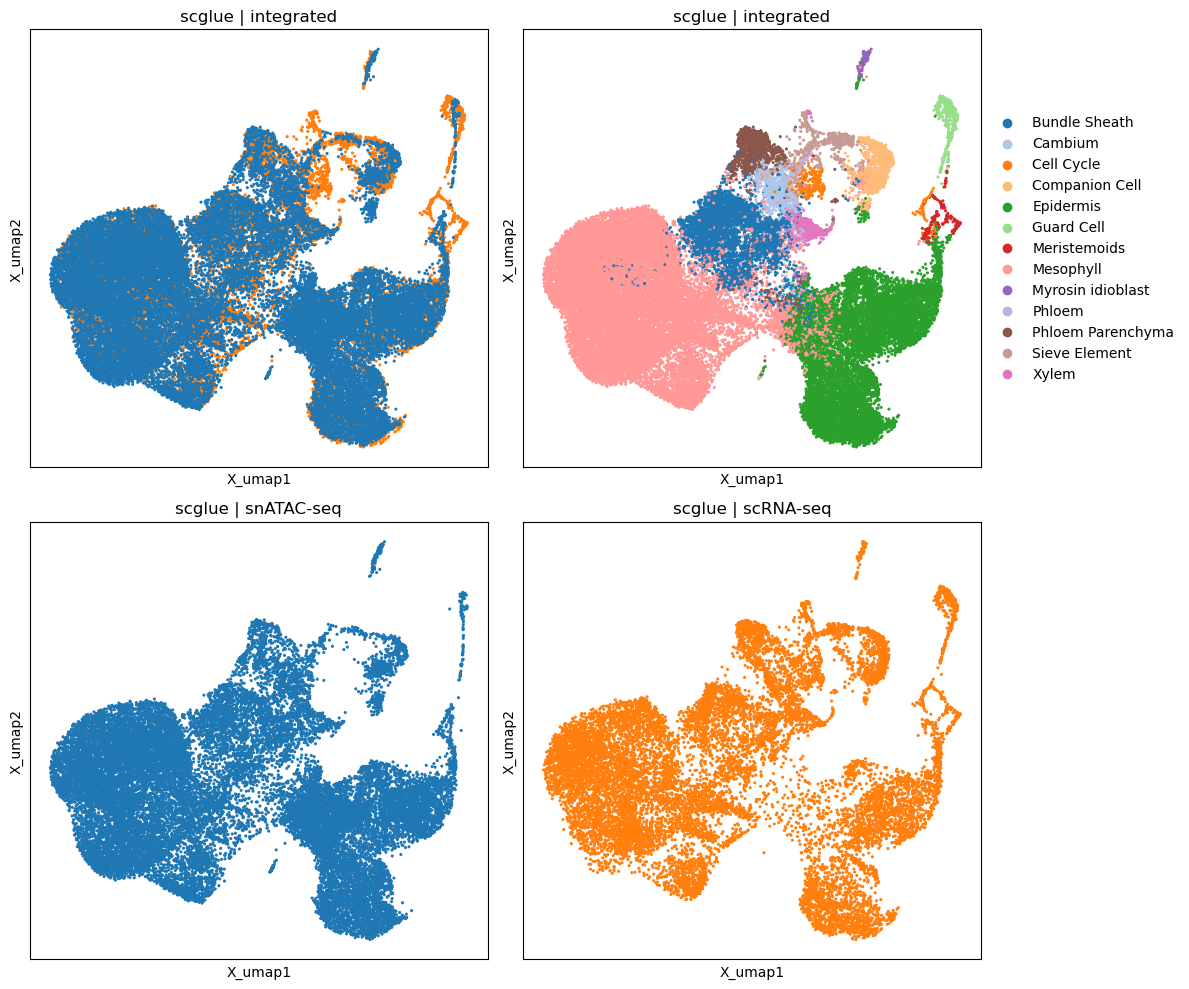

In [147]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sc.pl.embedding(
	scglue_adata,
	basis="X_umap",
	color="dataset",
	use_raw=None,
	layer=None,
	legend_loc=None,
	title="scglue | integrated",
	size=20,
	ax=axes[0, 0],
	show=False
)

sc.pl.embedding(
	scglue_adata,
	basis="X_umap",
	color="cell_type_v2",
	use_raw=None,
	layer=None,
	palette=sc.pl.palettes.vega_20,
	legend_loc="right margin",
	title="scglue | integrated",
	size=20,
	ax=axes[0, 1],
	show=False
)

sc.pl.embedding(
	scglue_adata[scglue_adata.obs["dataset"] == "ATAC"],
	basis="X_umap",
	color="dataset",
	use_raw=None,
	layer=None,
	legend_loc=None,
	title="scglue | snATAC-seq",
	size=20,
	ax=axes[1, 0],
	show=False
)

sc.pl.embedding(
	scglue_adata[scglue_adata.obs["dataset"] == "RNA"],
	basis="X_umap",
	color="dataset",
	use_raw=None,
	layer=None,
	legend_loc=None,
	title="scglue | scRNA-seq",
	size=20,
	ax=axes[1, 1],
	show=False
)

plt.tight_layout()
plt.show()

### ATAC & RNA marker 表达模式图

In [175]:
def _plot_multiome_patterns(
    rna_adata: ad.AnnData,
    atac_adata: ad.AnnData,
    rna_layer: Optional[str] = None,
    atac_layer: Optional[str] = None,
    cluster_label: str = None,
    cluster_order: Optional[list] = None,
    gene_lst: Optional[list] = None,
    output_path: Optional[str] = None
) -> None:
    """
    This function visualizes the gene expression (RNA-seq) and ATAC-seq patterns across cell types.
    It outputs a heatmap for RNA and ATAC data in common and separate hierarchical orders.

    Args:
        rna_adata (ad.AnnData): AnnData object containing RNA-seq data.
        atac_adata (ad.AnnData): AnnData object containing ATAC-seq data.
        rna_layer (str, optional): The RNA-seq layer to use (default is None, which uses the main matrix).
        atac_layer (str, optional): The ATAC-seq layer to use (default is None, which uses the main matrix).
        cluster_label (str): The column name in .obs of the AnnData object that specifies the cell type (default is None).
        cluster_order (list, optional): The order of cell types to display (default is None).
        gene_lst (list, optional): Gene list to display (default is None).
        output_path (str, optional): Path to save the output figure (default is None, which means no saving).

    Returns:
        None
    """
    # Process RNA-seq data
    if cluster_order:
        rna_adata = rna_adata[rna_adata.obs[cluster_label].isin(cluster_order)]

    rna_data = rna_adata.X if isinstance(
        rna_adata.X, np.ndarray) else rna_adata.X.toarray()
    if rna_layer:
        rna_data = rna_adata.layers[rna_layer] if isinstance(
            rna_adata.layers[rna_layer], np.ndarray) else rna_adata.layers[rna_layer].toarray()

    rna_data = pd.DataFrame(rna_data)
    rna_data.index = rna_adata.obs.index
    rna_data.columns = rna_adata.var.index
    rna_data["cell_type"] = rna_adata.obs[cluster_label]

    # Convert to sparse matrix before groupby mean calculation
    rna_sparse_data = csr_matrix(rna_data.drop(columns=["cell_type"]).values)
    rna_sparse_df = pd.DataFrame.sparse.from_spmatrix(rna_sparse_data)
    rna_sparse_df.index = rna_data.index
    rna_sparse_df.columns = rna_data.drop(columns=["cell_type"]).columns

    # Group by cell_type and calculate the mean (will remain sparse)
    rna_grouped = rna_sparse_df.groupby(rna_data["cell_type"]).mean()

    # Convert back to dense matrix after groupby
    rna_data = rna_grouped.T.sparse.to_dense()

    # Normalize RNA data
    rna_data = rna_data.apply(lambda x: (
        x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else x, axis=1).fillna(0)
    if cluster_order:
        rna_data = rna_data[cluster_order]

    # Process ATAC-seq data
    if cluster_order:
        atac_adata = atac_adata[atac_adata.obs[cluster_label].isin(
            cluster_order)]

    atac_data = atac_adata.X if isinstance(
        atac_adata.X, np.ndarray) else atac_adata.X.toarray()
    if atac_layer:
        atac_data = atac_adata.layers[atac_layer] if isinstance(
            atac_adata.layers[atac_layer], np.ndarray) else atac_adata.layers[atac_layer].toarray()

    atac_data = pd.DataFrame(atac_data)
    atac_data.index = atac_adata.obs.index
    atac_data.columns = atac_adata.var.index
    atac_data["cell_type"] = atac_adata.obs[cluster_label]

    # Convert to sparse matrix before groupby mean calculation
    atac_sparse_data = csr_matrix(atac_data.drop(columns=["cell_type"]).values)
    atac_sparse_df = pd.DataFrame.sparse.from_spmatrix(atac_sparse_data)
    atac_sparse_df.index = atac_data.index
    atac_sparse_df.columns = atac_data.drop(columns=["cell_type"]).columns

    # Group by cell_type and calculate the mean (will remain sparse)
    atac_grouped = atac_sparse_df.groupby(atac_data["cell_type"]).mean()

    # Convert back to dense matrix after groupby
    atac_data = atac_grouped.T.sparse.to_dense()

    # Normalize ATAC data
    atac_data = atac_data.apply(lambda x: (
        x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else x, axis=1).fillna(0)
    if cluster_order:
        atac_data = atac_data[cluster_order]

    # Hierarchical clustering on RNA-seq data
    rna_distances = pdist(rna_data, metric='euclidean')
    rna_linkage = linkage(rna_distances, method='average')
    rna_order = leaves_list(rna_linkage)
    rna_data = rna_data.iloc[rna_order, :]

    # Hierarchical clustering on ATAC-seq data
    atac_data_common = atac_data.reindex(rna_data.index).dropna()
    atac_distances = pdist(atac_data_common, metric='euclidean')
    atac_linkage = linkage(atac_distances, method='average')
    atac_order = leaves_list(atac_linkage)
    atac_data_separated = atac_data_common.iloc[atac_order, :]

    if gene_lst:
        rna_data = rna_data.loc[gene_lst]
        atac_data = atac_data_separated.loc[gene_lst]

        # Plot the results
        fig, axes = plt.subplots(1, 2, figsize=(18, 8))

        # Plot RNA heatmap
        ax = axes[0]
        im = ax.imshow(rna_data, cmap="coolwarm", aspect="auto")
        ax.set_title("scRNA-seq")
     
        fig.colorbar(im, ax=ax)

        # Set x-axis labels and rotate them
        ax.set_xticks(range(rna_data.shape[1]))  # Set x-ticks positions
        ax.set_xticklabels(rna_data.columns, rotation=90)
        
        ax.set_yticks(range(len(gene_lst)))
        ax.set_yticklabels(gene_lst)

        # Plot ATAC heatmap (common order)
        ax = axes[1]
        im = ax.imshow(atac_data, cmap="coolwarm", aspect="auto")
        ax.set_title("snATAC-seq")
        
        fig.colorbar(im, ax=ax)

        # Set x-axis labels and rotate them
        ax.set_xticks(range(atac_data.shape[1]))  # Set x-ticks positions
        ax.set_xticklabels(rna_data.columns, rotation=90)

        ax.set_yticks(range(len(gene_lst)))
        ax.set_yticklabels(gene_lst)

        plt.tight_layout()

        # Save the figure if output_path is provided
        if output_path:
            plt.savefig(output_path)

        plt.show()

    else:
        # Plot the results
        fig, axes = plt.subplots(2, 2, figsize=(18, 16))

        # Plot RNA heatmap
        ax = axes[0, 0]
        im = ax.imshow(rna_data, cmap="coolwarm", aspect="auto")
        
        ax.set_title("scRNA-seq")
        
        fig.colorbar(im, ax=ax, label="Normalized Expression")

        # Set x-axis labels and rotate them
        ax.set_xticks(range(rna_data.shape[1]))  # Set x-ticks positions
        ax.set_xticklabels(rna_data.columns, rotation=90)

        # Plot ATAC heatmap (common order)
        ax = axes[0, 1]
        im = ax.imshow(atac_data_common, cmap="coolwarm", aspect="auto")
        
        ax.set_title("snATAC-seq")
        
        fig.colorbar(im, ax=ax, label="Normalized Expression")

        # Set x-axis labels and rotate them
        # Set x-ticks positions
        ax.set_xticks(range(atac_data_common.shape[1]))
        ax.set_xticklabels(atac_data_common.columns, rotation=90)

        # Plot RNA heatmap again
        ax = axes[1, 0]
        im = ax.imshow(rna_data, cmap="coolwarm", aspect="auto")
        
        ax.set_title("scRNA-seq")
        
        fig.colorbar(im, ax=ax, label="Normalized Expression")

        # Set x-axis labels and rotate them
        ax.set_xticks(range(rna_data.shape[1]))  # Set x-ticks positions
        ax.set_xticklabels(rna_data.columns, rotation=90)

        # Plot ATAC heatmap (separate order)
        ax = axes[1, 1]
        im = ax.imshow(atac_data_separated, cmap="coolwarm", aspect="auto")
        
        ax.set_title("snATAC-seq")
        
        fig.colorbar(im, ax=ax, label="Normalized Expression")

        # Set x-axis labels and rotate them
        # Set x-ticks positions
        ax.set_xticks(range(atac_data_separated.shape[1]))
        ax.set_xticklabels(atac_data_separated.columns, rotation=90)

        plt.tight_layout()

        # Save the figure if output_path is provided
        if output_path:
            plt.savefig(output_path)

        plt.show()

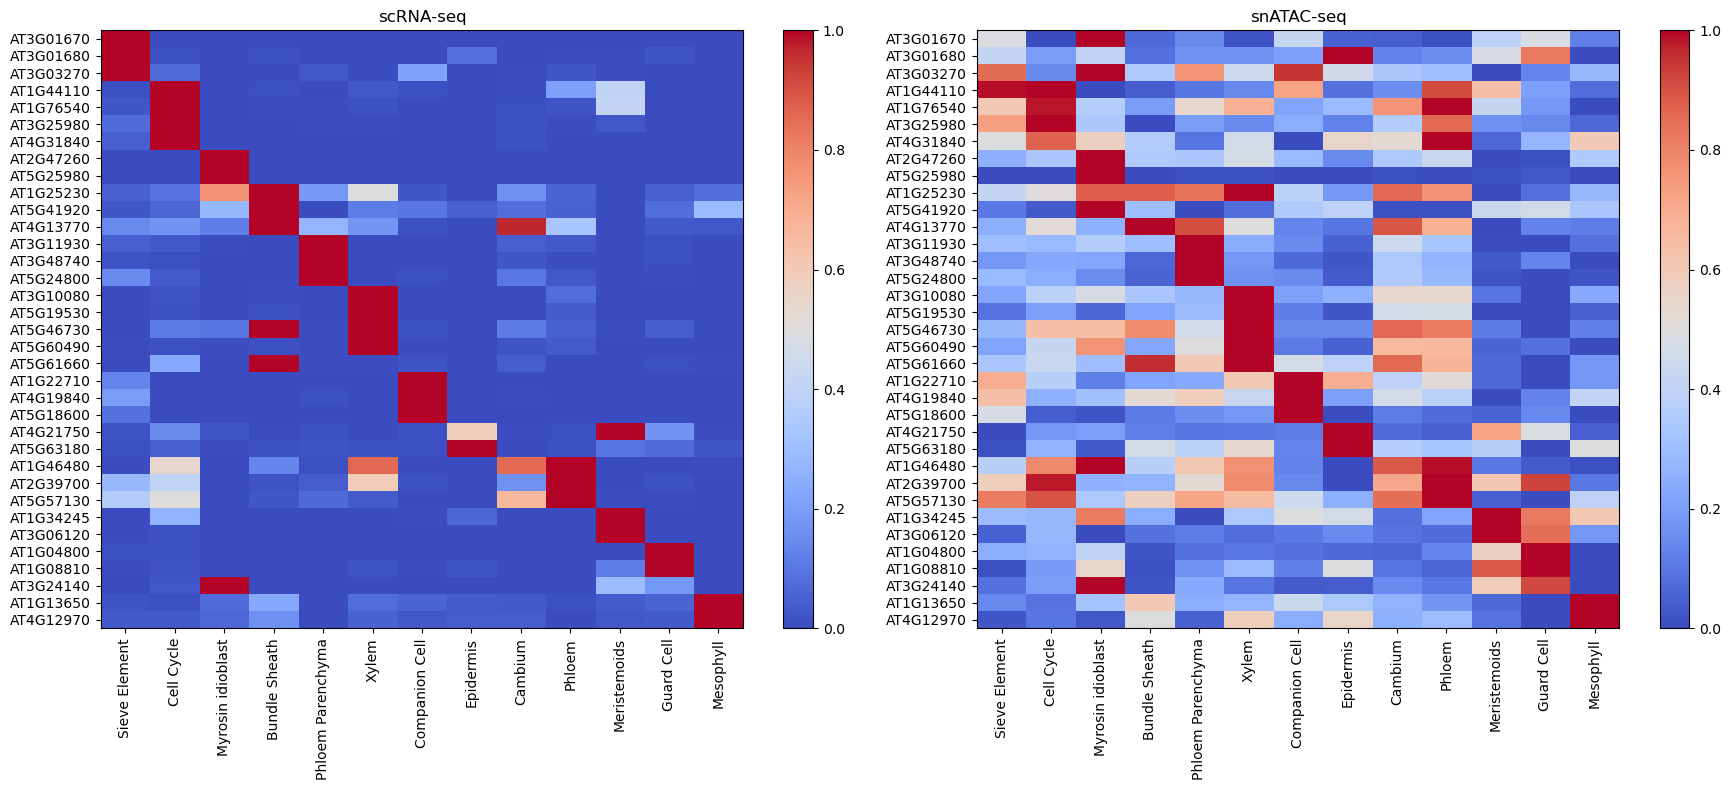

In [177]:
markers_lst = [
    "AT3G01670", "AT3G01680", "AT3G03270", # Sieve Element
    "AT1G44110", "AT1G76540", "AT3G25980", "AT4G31840", # Cell Cycle
    "AT2G47260", "AT5G25980", # Myrosin Idioblast
    "AT1G25230", "AT5G41920", "AT4G13770", # Bundle Sheath
    "AT3G11930", "AT3G48740", "AT5G24800", # Phloem Parenchyma
    "AT3G10080", "AT5G19530", "AT5G46730", "AT5G60490", "AT5G61660", # Xylem
    "AT1G22710", "AT4G19840", "AT5G18600", # Companion Cell
    "AT4G21750", "AT5G63180", # Epidermis
    "AT1G46480", "AT2G39700", # Cambium
    "AT5G57130", # Phloem
    "AT1G34245", "AT3G06120", # Meristemoids
    "AT1G04800", "AT1G08810", "AT3G24140", # Guard Cell
    "AT1G13650", "AT4G12970", # Mesophyll
]

cell_type_order = ["Sieve Element", "Cell Cycle", "Myrosin idioblast", "Bundle Sheath", "Phloem Parenchyma", "Xylem", "Companion Cell", "Epidermis", "Cambium", "Phloem", "Meristemoids", "Guard Cell", "Mesophyll"]

_plot_multiome_patterns(
    rna_adata=rna_adata, 
    atac_adata=atac_gene_mat_adata, 
    rna_layer="counts", 
    atac_layer=None, 
    cluster_label="cell_type_scglue", 
    cluster_order=cell_type_order,
    gene_lst=markers_lst,
    output_path=None
)

### ATAC & RNA 相关性热图

In [183]:
def _plot_correlation_heatmap(
    rna_adata: sc.AnnData,
    atac_adata: sc.AnnData,
    rna_layer: Optional[str] = None,
    atac_layer: Optional[str] = None,
    cluster_label: str = "cell_type",
    output_path: Optional[str] = None
) -> None:
    """Plot a correlation heatmap between scRNA-seq and snATAC-seq.

    Args:
        rna_adata (AnnData): scRNA-seq data in AnnData format.
        atac_adata (AnnData): snATAC-seq data in AnnData format.
        rna_layer (Optional[str]): Layer name for scRNA-seq data (default: None).
        atac_layer (Optional[str]): Layer name for snATAC-seq data (default: None).
        cluster_label (str): Column name in `obs` used for grouping cell types.
        output_path (Optional[str]): Path to save the heatmap image (default: None).

    Returns:
        None
    """
    # Extract scRNA-seq data
    rna_matrix = (
        rna_adata.layers[rna_layer] if rna_layer else rna_adata.raw.X
    )
    rna_matrix = rna_matrix.toarray() if not isinstance(
        rna_matrix, np.ndarray) else rna_matrix

    rna_df = pd.DataFrame(
        rna_matrix, index=rna_adata.obs.index, columns=rna_adata.var.index)
    rna_df = rna_df.loc[:, rna_adata.var["highly_variable"].tolist()]
    rna_df["cell_type"] = rna_adata.obs[cluster_label]

    # Convert to sparse before groupby mean
    rna_sparse = csr_matrix(rna_df.drop(columns=["cell_type"]).values)
    rna_sparse_df = pd.DataFrame.sparse.from_spmatrix(
        rna_sparse, index=rna_df.index, columns=rna_df.drop(columns=["cell_type"]).columns)
    rna_grouped = rna_sparse_df.groupby(rna_df["cell_type"]).mean()

    # Convert back to dense matrix
    rna_df = rna_grouped.T.sparse.to_dense()
    rna_df = rna_df.apply(lambda x: (x - x.min()) / (x.max() - x.min())
                          if x.max() != x.min() else x, axis=1).fillna(0)

    # Extract snATAC-seq data
    atac_matrix = (
        atac_adata.layers[atac_layer] if atac_layer else atac_adata.raw.X
    )
    atac_matrix = atac_matrix.toarray() if not isinstance(
        atac_matrix, np.ndarray) else atac_matrix

    atac_df = pd.DataFrame(
        atac_matrix, index=atac_adata.obs.index, columns=atac_adata.var.index)
    atac_df["cell_type"] = atac_adata.obs[cluster_label]

    # ** Ensure both datasets have common features **
    common_features = rna_adata.var.index[rna_adata.var["highly_variable"]].intersection(
        atac_df.columns)
    rna_df = rna_df.loc[common_features]
    atac_df = atac_df.loc[:, common_features.tolist() + ["cell_type"]]

    # Convert to sparse before groupby mean
    atac_sparse = csr_matrix(atac_df.drop(columns=["cell_type"]).values)
    atac_sparse_df = pd.DataFrame.sparse.from_spmatrix(
        atac_sparse, index=atac_df.index, columns=atac_df.drop(columns=["cell_type"]).columns)
    atac_grouped = atac_sparse_df.groupby(atac_df["cell_type"]).mean()

    # Convert back to dense matrix
    atac_df = atac_grouped.T.sparse.to_dense()
    atac_df = atac_df.apply(lambda x: (
        x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else x, axis=1).fillna(0)

    # Compute correlation matrix
    correlation_matrix = pd.DataFrame(
        np.corrcoef(rna_df, atac_df, rowvar=False)[
            rna_df.shape[1]:, :rna_df.shape[1]],
        index=rna_df.columns,
        columns=atac_df.columns
    )

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", cbar=True)
    plt.title("")
    plt.xlabel("scRNA-seq")
    plt.ylabel("snATAC-seq")
    plt.tight_layout()

    # Save if output path is provided
    if output_path:
        plt.savefig(output_path)

    plt.show()

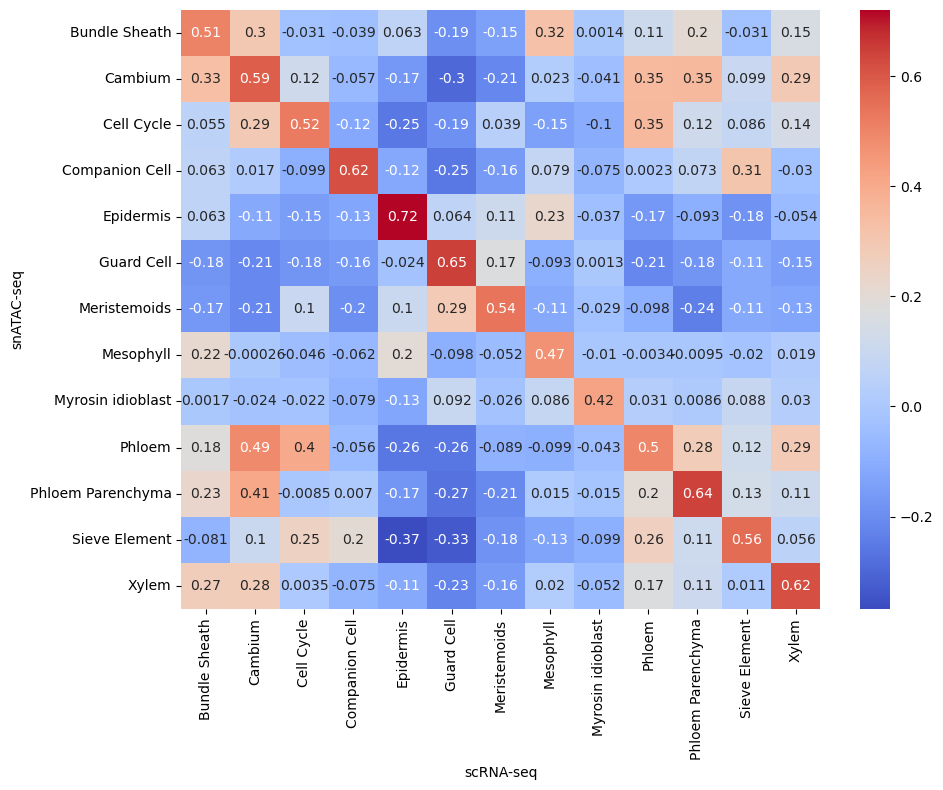

In [184]:
_plot_correlation_heatmap(
    rna_adata=rna_adata,
    atac_adata=atac_gene_mat_adata,
    rna_layer=None,
    atac_layer=None,
    cluster_label="cell_type_scglue", 
    output_path=None
)

### RNA 数据质量展示图

/tmp/ipykernel_1532158/611948282.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_1532158/611948282.py:44: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_1532158/611948282.py:59: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




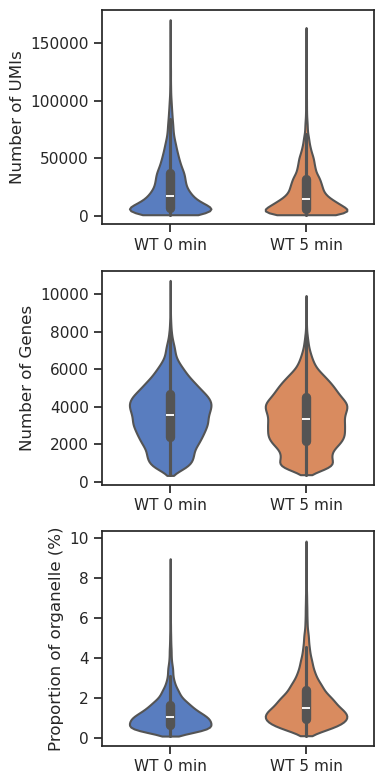

In [288]:
umi_data = pd.DataFrame({
    "UMIs": pd.concat([
        rna_ctrl_adata.obs["total_counts"],
        rna_treat_adata.obs["total_counts"]
    ]),
    "Condition": ["WT 0 min"] * rna_ctrl_adata.n_obs + ["WT 5 min"] * rna_treat_adata.n_obs
})

gene_counts_data = pd.DataFrame({
    "n_genes_by_counts": pd.concat([
        rna_ctrl_adata.obs["n_genes_by_counts"],
        rna_treat_adata.obs["n_genes_by_counts"]
    ]),
    "Condition": ["WT 0 min"] * rna_ctrl_adata.n_obs + ["WT 5 min"] * rna_treat_adata.n_obs
})

organelle_pct_data = pd.DataFrame({
    "pct_counts_organelle": pd.concat([
        rna_ctrl_adata.obs["pct_counts_organelle"],
        rna_treat_adata.obs["pct_counts_organelle"]
    ]),
    "Condition": ["WT 0 min"] * rna_ctrl_adata.n_obs + ["WT 5 min"] * rna_treat_adata.n_obs
})

sns.set(style="ticks")

fig, axes = plt.subplots(3, 1, figsize=(4, 8))

sns.violinplot(
    data=umi_data,
    x="Condition",
    y="UMIs",
    palette="muted",
    cut=0,
    inner="box",
    linewidth=1.5,
    width=0.6,
    ax=axes[0]
)
axes[0].set_title("")
axes[0].set_xlabel("")
axes[0].set_ylabel("Number of UMIs", fontsize=12)

sns.violinplot(
    data=gene_counts_data,
    x="Condition",
    y="n_genes_by_counts",
    palette="muted",
    cut=0,
    inner="box",
    linewidth=1.5,
    width=0.6,
    ax=axes[1]
)
axes[1].set_title("")
axes[1].set_xlabel("")
axes[1].set_ylabel("Number of Genes", fontsize=12)

sns.violinplot(
    data=organelle_pct_data,
    x="Condition",
    y="pct_counts_organelle",
    palette="muted",
    cut=0,
    inner="box",
    linewidth=1.5,
    width=0.6,
    ax=axes[2]
)
axes[2].set_title("")
axes[2].set_xlabel("")
axes[2].set_ylabel("Proportion of organelle (%)", fontsize=12)

plt.tight_layout()
plt.show()

### ATAC 数据质量展示图

/tmp/ipykernel_1532158/2067022320.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_1532158/2067022320.py:44: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_1532158/2067022320.py:59: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




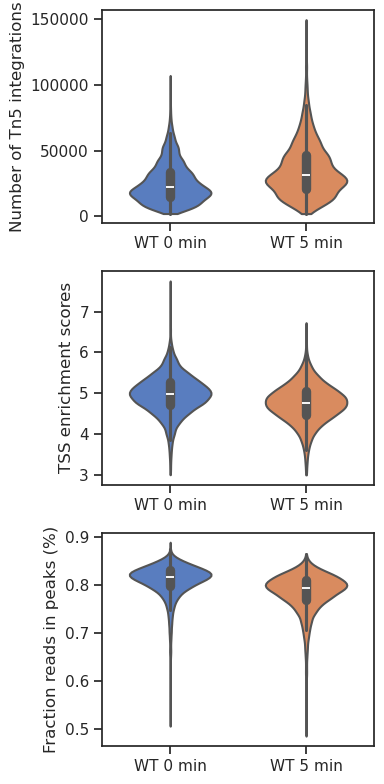

In [289]:
num_fragments_data = pd.DataFrame({
    "Fragments": pd.concat([
        atac_ctrl_adata.obs["n_fragment"],
        atac_treat_adata.obs["n_fragment"]
    ]),
    "Condition": ["WT 0 min"] * atac_ctrl_adata.n_obs + ["WT 5 min"] * atac_treat_adata.n_obs
})

tsse_data = pd.DataFrame({
    "Tsse": pd.concat([
        atac_ctrl_adata.obs["tsse"],
        atac_treat_adata.obs["tsse"]
    ]),
    "Condition": ["WT 0 min"] * atac_ctrl_adata.n_obs + ["WT 5 min"] * atac_treat_adata.n_obs
})

pct_peaks_data = pd.DataFrame({
    "Peaks": pd.concat([
        atac_ctrl_adata.obs["Peaks"],
        atac_treat_adata.obs["Peaks"]
    ]),
    "Condition": ["WT 0 min"] * atac_ctrl_adata.n_obs + ["WT 5 min"] * atac_treat_adata.n_obs
})

sns.set(style="ticks")

fig, axes = plt.subplots(3, 1, figsize=(4, 8))

sns.violinplot(
    data=num_fragments_data,
    x="Condition",
    y="Fragments",
    palette="muted",
    cut=0,
    inner="box",
    linewidth=1.5,
    width=0.6,
    ax=axes[0]
)
axes[0].set_title("")
axes[0].set_xlabel("")
axes[0].set_ylabel("Number of Tn5 integrations", fontsize=12)

sns.violinplot(
    data=tsse_data,
    x="Condition",
    y="Tsse",
    palette="muted",
    cut=0,
    inner="box",
    linewidth=1.5,
    width=0.6,
    ax=axes[1]
)
axes[1].set_title("")
axes[1].set_xlabel("")
axes[1].set_ylabel("TSS enrichment scores", fontsize=12)

sns.violinplot(
    data=pct_peaks_data,
    x="Condition",
    y="Peaks",
    palette="muted",
    cut=0,
    inner="box",
    linewidth=1.5,
    width=0.6,
    ax=axes[2]
)
axes[2].set_title("")
axes[2].set_xlabel("")
axes[2].set_ylabel("Fraction reads in peaks (%)", fontsize=12)

plt.tight_layout()
plt.show()